## Anaomaly Detection Technoques examples and Code Usage

-----
### Technique-1: Kmeans

**Description:** Kmeans clustering algorithm is used

In [23]:
# Importing the methods of  kmeans_anomaly file 
from anaomaly import get_Dist_Point, close_price, km_n_clusters, find_tr, plot_outliers

In [1]:
# Importing Necessary libraries
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
register_matplotlib_converters()
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = np.random.seed(0)

In [2]:
# data description
df1 = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
df1["close"].head(10) # first 10 data points used in forecasting

date
1986-01-02    209.59
1986-01-03    210.88
1986-01-06    210.65
1986-01-07    213.80
1986-01-08    207.97
1986-01-09    206.11
1986-01-10    205.96
1986-01-13    206.72
1986-01-14    206.64
1986-01-15    208.26
Name: close, dtype: float64

In [15]:
df1["close"].shape # size of the the data

(8192,)

In [19]:
df1["close"].index[0] # Start Date

Timestamp('1986-01-02 00:00:00')

In [22]:
df1["close"].index[-1] # End Date

Timestamp('2018-06-29 00:00:00')

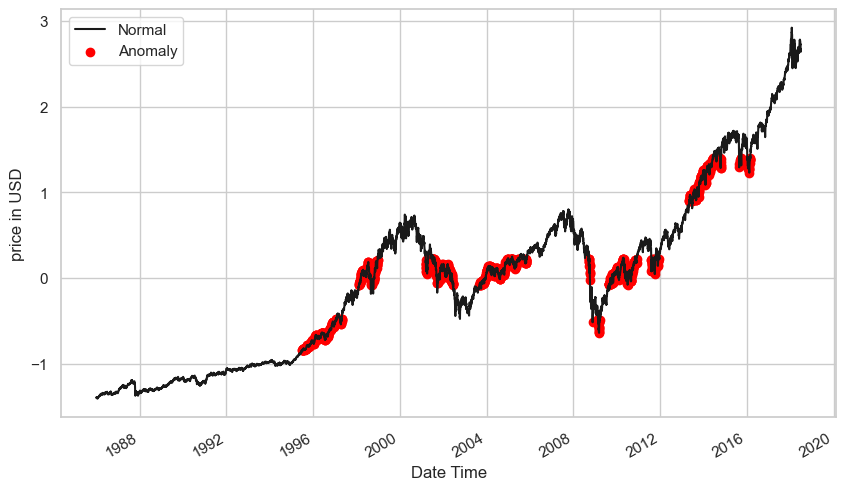

In [4]:
# load the data
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

# select different hyperparameters
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(df) for i in n_cluster]
scores = [kmeans[i].score(df) for i in range(len(kmeans))]

# closing price as input data
X = close_price(df)

# K-means with 10 clusters 
km = KMeans(n_clusters=7)
km.fit(X)
#km = km_n_clusters(10, X)
km.predict(X)
labels = km.labels_


# data scaling and transformations
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df)
data = pd.DataFrame(np_scaled)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
data['cluster'] = kmeans[9].predict(data)
data.index = data.index


outliers_fraction = 0.25
distance = get_Dist_Point(data, kmeans[9])

# find the treshold
threshold = find_tr(outliers_fraction,distance)
data['anomaly1'] = (distance >= threshold).astype(int)
data.index = df.index
a = data.loc[data['anomaly1'] == 1]

# plot the outliers
plot_outliers(a,df,data)



### Analyse the observations:
- The time series data certainly has anomalies and their patterns are shown in the inflection points.
- There are no concrete proof of anomalies but similar trends are shown for all algorithms.

-----
### Technique-2: Isolation Forest

## Description

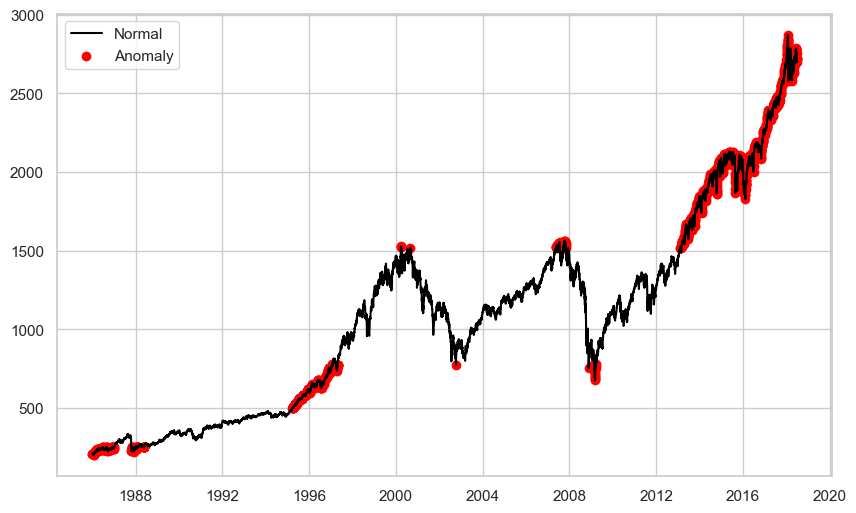

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = np.random.seed(1)


def parser(s):
    return datetime.strptime(s, '%d-%m-%Y')

# df = pd.read_csv('spx.csv', parse_dates=[0], index_col=0, date_parser=parser)
# load the data
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
outliers_frac = float(.25)

scaler = StandardScaler()
np_scalar = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scalar)

# train the isolation forest algorithm
model =  IsolationForest(contamination=outliers_frac)
model.fit(data) 

df['anomaly'] = model.predict(data)

# visualization of outliers
fig, ax = plt.subplots(figsize=(10,6))

A = df.loc[df['anomaly'] == -1, ['close']] #anomaly

ax.plot(df.index, df['close'], color='black', label = 'Normal')
ax.scatter(A.index,A['close'], color='red', label = 'Anomaly')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.show();



## Analyse the observations:
1. Isolation Forest algorithm is very precise in detecting anomalies.

-----
### Technique-3: Simple LSTM

**Description:** 

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [4]:
from anaomaly2 import create_dataset, create_model 

In [5]:
# setting up plot space
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42

# everythime data is shuffled, data is to be same
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# load the data
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')



In [6]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])


TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)


# Train the model using batch normalization
model = create_model(X_train)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=50,
    validation_split=0.3,
    shuffle=False
)


X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)


X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)



Epoch 1/5
86/86 [==============================] - 7s 44ms/step - loss: 0.2416 - val_loss: 0.3220
Epoch 2/5
86/86 [==============================] - 3s 39ms/step - loss: 0.1931 - val_loss: 0.3149
Epoch 3/5
86/86 [==============================] - 4s 49ms/step - loss: 0.1698 - val_loss: 0.3388
Epoch 4/5
86/86 [==============================] - 4s 50ms/step - loss: 0.1469 - val_loss: 0.3820
Epoch 5/5
64/64 [==============================] - 1s 9ms/step


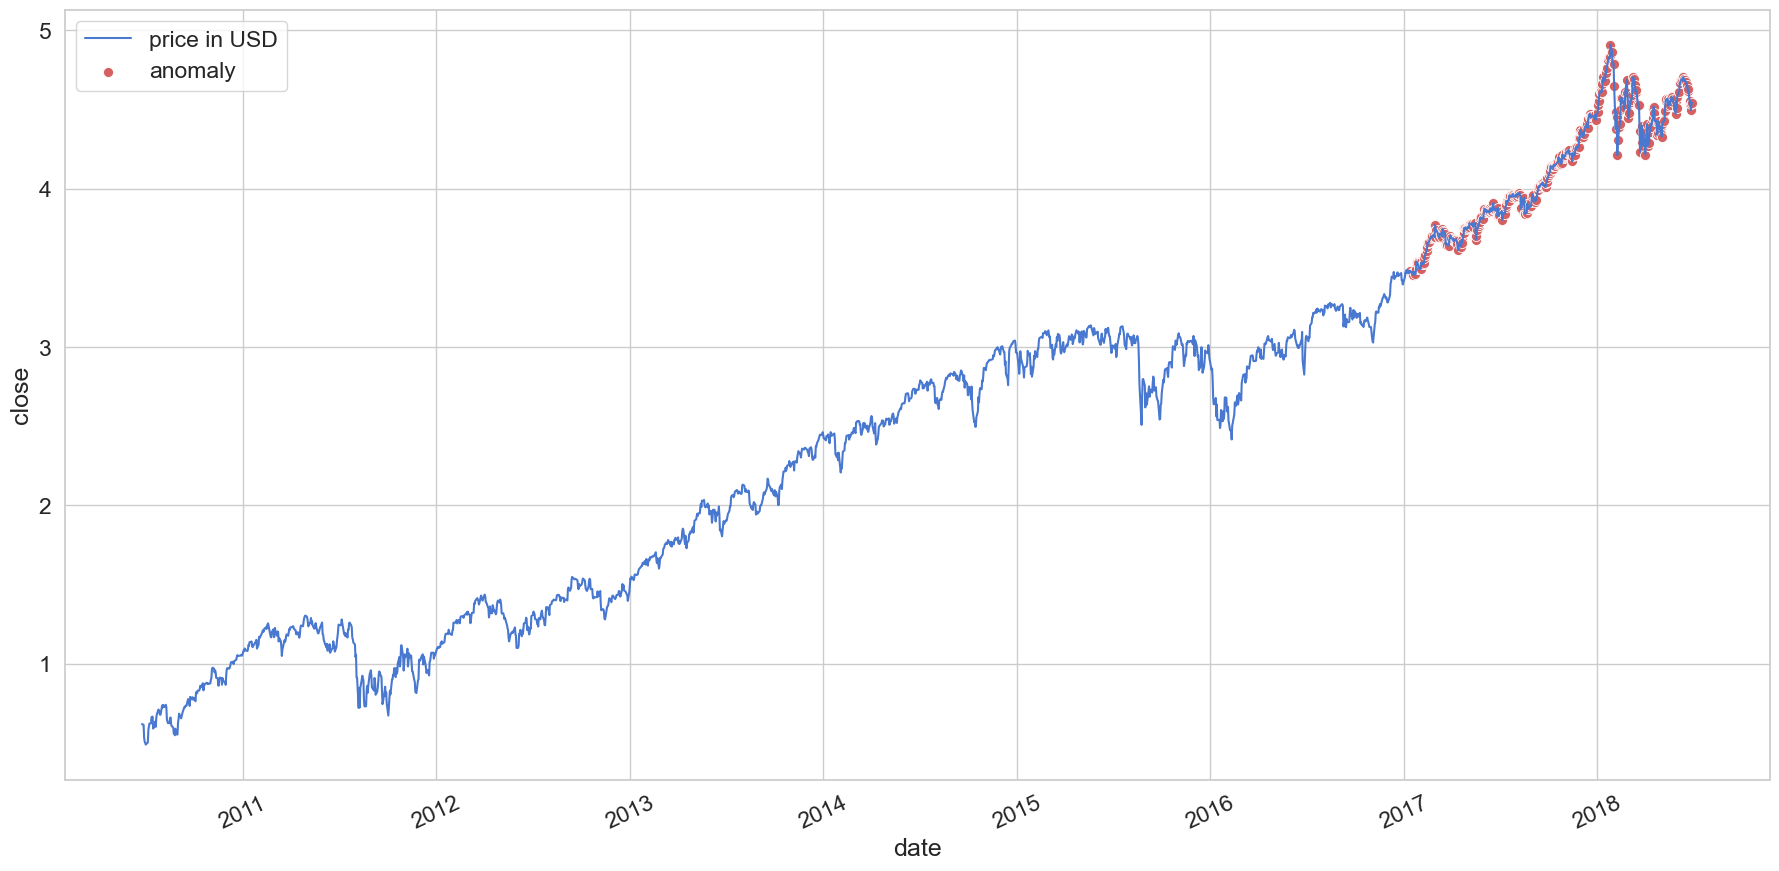

In [7]:

# Set the treshold value
THRESHOLD = np.max(train_mae_loss)*2.5

test_score_df = pd.DataFrame(index= test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold # Value above treshold is classifed as anomaly.
test_score_df['close'] = test[TIME_STEPS:].close

anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  test[TIME_STEPS:].index, 
  (test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  x=anomalies.index,
  y=(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

## Analyse the observations:
- Data is folded monthly because the LSTM algorithm works good for stationery time series signals well.
- Output is prety much changed drastically. This is due to no large fluctuation in the data.

## Overall Analysis
- From all the 3 algorithms 
    - LSTM and Isolation Forest has some sort of similarity
    - Insolation Forest and K-Means has good similarity.
- Therefore, one can decinde only after using the all 3 algorithms todecide weather the data point is outlier or regular point.